# User Input

Insert your File's path here:

In [0]:
# p='/content/drive/My Drive/Fac/bc 7/'

Inser here the Year and Month you want to consider for the beggining of the test set:

In [0]:
test_month=8
test_year=2014

# Set up

In [0]:
# from google.colab import drive
# drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
 # Import packages
import csv
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import folium
from numpy.linalg import norm
import scipy.stats as ss
from datetime import timedelta
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [0]:
def other_percs(data, subset, Value):
    d = {'Total': subset, 
     'Percentage (%)': (subset/len(data))*100}
    df = pd.DataFrame(data=d)
    del d
    df['Percentage (%)'] = df['Percentage (%)'].apply('{:.2f}%'.format)
    df.reset_index(inplace=True)
    df.rename(columns={'index':Value}, inplace=True)
    return df

Data Transformation Functions

In [0]:
def Same_Order_same_Day(data):
  data_use=data[['Order', 'Member', 'date']]
  group_orders=pd.pivot_table(data=data_use, index=['Member', 'date'], aggfunc='first')
  group_orders.reset_index(inplace=True)
  data.drop(columns='Order', inplace=True)
  data=data.merge(group_orders, how='left', on=['Member', 'date'])
  data = data.drop(['index'], axis=1)
  return data
  
def Delete_less4items(data):
  # Count the number of items per order 
  aux_test = data.groupby('Order').count()['Member']
  # Merge the items per order count to the test set
  data = pd.merge(data, aux_test, left_on = 'Order', right_index = True, how = 'left').rename(columns = {'Member_y' : 'itemsPerOrder', 'Member_x' : 'Member'})
  print((data[data.itemsPerOrder<5].shape[0]/data.shape[0])*100, '% of the records have been removed.')
  data = data[data['itemsPerOrder'] >= 5]
  data.drop(columns=['itemsPerOrder'], inplace = True)
  return data

Page Rank & Similarity Measures Functions

In [0]:
def create_purch(data):
  purch=pd.pivot_table(data[['SKU_des', 'Order', 'Description']], index='Order', columns='SKU_des', 
                       aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0).astype(int)
  purch.columns=purch.columns.droplevel()
  return purch

#####################################################################################
# Page rank functions

def create_coocc(data):
  purch=create_purch(data)
  #Creating the Co-occorence table by multiplying the matrix with its transpose
  coocc = purch.T.dot(purch)
  np.fill_diagonal(coocc.values, 0)
  return coocc

def rel_coef_matrix(data):
  coocc=create_coocc(data)
  coocc['rowSum']=coocc.sum(axis=1)
  #calculate Relationship coefficient between items 
  coocc.iloc[:,:-1]=coocc.iloc[:,:-1]/coocc.iloc[:,-1]
  coocc.drop(columns='rowSum', inplace=True)
  coocc=coocc.fillna(0)
  return coocc

def getTeleMatrix(A,m):
 """ return the matrix M
     of the web described by A """
 n = A.shape[1]
 S = ones((n,n))/n
 return (1-m)*A+m*S

def powerMethod(A,x0,m,iter):
 """ power method modified to compute
     the maximal real eigenvector 
     of the matrix M built on top of the input matrix A """
 n = A.shape[1]
 delta = m*(array([1]*n,dtype='float64')/n) # array([1]*n is [1 1 ... 1] n times
 for i in range(iter):
  x0 = dot((1-m),dot(A,x0)) + delta
 return x0

def ranked_skus(data, member):
  #Order=data[data.Member==member].sort_values('Order', ascending = False).Order.unique()[2:10]
  #use_data=data[(data.Member==member) & (data.Order.isin(Order))]
  use_data=data[(data.Member==member)]
  matrix=rel_coef_matrix(use_data)
  A = np.array(matrix)
  n = A.shape[1]
  m = 1/n
  M = getTeleMatrix(A,m)

  x0 = [1]*n
  x1 = pd.Series(powerMethod(A,x0,m,200), name=member)
  rannked_Skus=pd.DataFrame(pd.concat([pd.Series(matrix.columns), x1], axis=1))
  rannked_Skus.sort_values(by=member, ascending=False, inplace=True)
  rannked_Skus.reset_index(inplace=True, drop=True)
  return rannked_Skus
  
def run_page_rank(data):

  skus=pd.DataFrame(pd.Series(list(set(data.SKU_des)), name='SKU_des'))
  for member in set(data.Member):
    testt=ranked_skus(data, member)
    skus=skus.merge(testt, how='left', on='SKU_des').fillna(0)
  return (skus)

def SmartBasket(data, topN):
    skus=pd.DataFrame()
    for member in set(data.Member):
      ranked=ranked_skus(data, member).loc[:topN,'SKU_des'].tolist()
      skus[member]=ranked
    return skus

def SmartBasket_newCust(data, topN):
    a=pd.pivot_table(data=data[['SKU_des', 'Order']], index='SKU_des', aggfunc='count')
    a.sort_values(by='Order', inplace=True, ascending=False)
    #a.iloc[:200,]
    top200_prods=list(a.iloc[:200,].index.values)
    data_SBNC=data[data.SKU_des.isin(top200_prods)]
    ranked=ranked_skus_NEWC(data_SBNC).loc[:topN,'SKU_des'].tolist()
    return ranked

def PageRank_nextBasket_newCust(data, basket, topN):
    ranked=ranked_skus_NEWC(data)
    ranked=ranked[~ranked.SKU_des.isin(basket)]
    ranked.reset_index(drop=True, inplace=True)
    ranked=ranked.loc[:topN,:]
    return ranked

def PageRank_nextBasket(data, member, basket, topN):
    ranked=ranked_skus(data, member)
    ranked=ranked[~ranked.SKU_des.isin(basket)]
    ranked.reset_index(drop=True, inplace=True)
    ranked=ranked.loc[:topN,:]
    return ranked

#####################################################################################
# simiarity measures functions

def create_similarity_matrix(data, member, similiarity_func_name):
  data=data[data.Member==member]
  purch=create_purch(data)
  similiriaty_matrix=pd.DataFrame(columns=purch.columns, index=purch.columns)
  for i in range(purch.shape[1]):
    for j in range(i+1,purch.shape[1]):
      similiriaty_matrix.iloc[i,j] =similiarity_func_name(purch.iloc[:,i], purch.iloc[:,j])
      similiriaty_matrix.iloc[j,i] = similiriaty_matrix.iloc[i,j]
  similiriaty_matrix.columns=similiriaty_matrix.columns.astype('str')
  similiriaty_matrix.index=similiriaty_matrix.index.astype('str')
  return similiriaty_matrix

def cosine_similarity(a,b):
  return dot(a, b)/(norm(a)*norm(b))

def jaccard_similarity(im1, im2):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    union= np.logical_or(im1, im2)

    return intersection.sum() / union.sum()


def dice_similarity(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

#https://gist.github.com/JDWarner/6730747

def rankdata(l):
  ranks=[sorted(l, reverse=True).index(x) for x in l]
  return ranks

def select_next_inBasket(data, member, similiarity_measure, basket, topN):
  mat=create_similarity_matrix(data, member, similiarity_measure).fillna(0)
  bask=mat.loc[mat.columns[~mat.columns.isin(basket)].tolist(), mat.index[mat.index.isin(basket)].tolist()]
  bask['Max Similiarity']=bask.max(axis=1).fillna(0)
  bask['Rank']=rankdata(bask['Max Similiarity'])
  sol=bask[bask.Rank<=topN].Rank
  sol=sol.sort_values()
  return sol

################################################################################
## New members did you forget - similiarity measures

def select_next_inBasket_NEWCust(data, similiarity_measure, basket, topN):
  mat=create_similarity_matrix_NEWC(data, similiarity_measure).fillna(0)
  bask=mat.loc[mat.columns[~mat.columns.isin(basket)].tolist(), mat.index[mat.index.isin(basket)].tolist()]
  bask['Max Similiarity']=bask.max(axis=1).fillna(0)
  bask['Rank']=rankdata(bask['Max Similiarity'])
  sol=bask[bask.Rank<=topN].Rank
  sol=sol.sort_values()
  return sol

def create_similarity_matrix_NEWC(data, similiarity_func_name):
  purch=create_purch(data)
  similiriaty_matrix=pd.DataFrame(columns=purch.columns, index=purch.columns)
  for i in range(purch.shape[1]):
    for j in range(i+1,purch.shape[1]):
      similiriaty_matrix.iloc[i,j] =similiarity_func_name(purch.iloc[:,i], purch.iloc[:,j])
      similiriaty_matrix.iloc[j,i] = similiriaty_matrix.iloc[i,j]
  similiriaty_matrix.columns=similiriaty_matrix.columns.astype('str')
  similiriaty_matrix.index=similiriaty_matrix.index.astype('str')
  return similiriaty_matrix

def select_next_inBasket_newCust(data, similiarity_measure, basket, topN):
  a=pd.pivot_table(data=data[['SKU_des', 'Order']], index='SKU_des', aggfunc='count')
  a.sort_values(by='Order', inplace=True, ascending=False)
  top200_prods=list(a.iloc[:200,].index.values)
  top200_prods.extend(basket)
  prods=list(set(top200_prods))
  data=data[data.SKU_des.isin(prods)]
  mat=create_similarity_matrix_NEWC(data, similiarity_measure).fillna(0)
  bask=mat.loc[mat.columns[~mat.columns.isin(basket)].tolist(), mat.index[mat.index.isin(basket)].tolist()]
  bask['Max Similiarity']=bask.max(axis=1).fillna(0)
  bask['Rank']=rankdata(bask['Max Similiarity'])
  sol=bask[bask.Rank<=topN].Rank
  sol=sol.sort_values()
  return sol
#################################################################################
## Nwe members did u forget - page rank

def PageRank_nextBasket_NEWC(data, basket, topN):
    ranked=ranked_skus_NEWC(data)
    ranked=ranked[~ranked.SKU_des.isin(basket)]
    ranked.reset_index(drop=True, inplace=True)
    ranked=ranked.loc[:topN,:]
    return ranked

def ranked_skus_NEWC(data):
  matrix=rel_coef_matrix(data)
  A = np.array(matrix)
  n = A.shape[1]
  m = 1/n
  M = getTeleMatrix(A,m)

  x0 = [1]*n
  x1 = pd.Series(powerMethod(A,x0,m,200), name='ranks')
  rannked_Skus=pd.DataFrame(pd.concat([pd.Series(matrix.columns), x1], axis=1))
  rannked_Skus.sort_values(by='ranks', ascending=False, inplace=True)
  rannked_Skus.reset_index(inplace=True, drop=True)
  return rannked_Skus

Market Basket Analysis Function

In [0]:
min_supp = 0.05
min_conf = 0.5
min_lift = 1.2

def Basket_analysis(df, member,  basket ,TopN, *args):
    
    recommend = []
    Member_history = df.loc[df.Member==member][['SKU_des', 'Order']]
    Member_history = Member_history.groupby('SKU_des').filter(lambda x : len(x)>5)
 
    
    Member_history_pivot = pd.pivot_table(Member_history, index='Order', columns='SKU_des',aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
    frequent_itemsets = apriori(Member_history_pivot, min_support=min_supp, use_colnames=True)
        
    rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
    subs_rules = rulesLift[['antecedents', 'consequents', 'lift', 'support', 'confidence']].sort_values(by=['lift'])
    
    subs_rules['antecedents_name'] = [','.join(list(x)) for x in subs_rules['antecedents']]
    subs_rules['consequents_name'] = [','.join(list(x)) for x in subs_rules['consequents']]
    subs_rules['antecedents_name'] = subs_rules['antecedents_name'].apply(str)

    for i in basket:
        if i in subs_rules['antecedents_name'].values.tolist():
            a = subs_rules['antecedents_name'].values.tolist().index(i)
            b = subs_rules['consequents_name'][a]
            
            if i not in b: 
                recommend.extend(b.split(','))
    return recommend

def Basket_analysis_new_customers(df,  basket ,TopN, *args):
   
    recommend = []
    Member_history = df[['Description', 'Order']]
    
    Member_history_pivot = pd.pivot_table(Member_history, index='Order', columns='Description',aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
    frequent_itemsets = apriori(Member_history_pivot, min_support=min_supp, use_colnames=True)
        
    rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
    subs_rules = rulesLift[['antecedents', 'consequents', 'lift', 'support', 'confidence']].sort_values(by=['lift'])
    
    subs_rules['antecedents_name'] = [','.join(list(x)) for x in subs_rules['antecedents']]
    subs_rules['consequents_name'] = [','.join(list(x)) for x in subs_rules['consequents']]
    subs_rules['antecedents_name'] = subs_rules['antecedents_name'].apply(str)

    for i in basket:
        if i in subs_rules['antecedents_name'].values.tolist():
            a = subs_rules['antecedents_name'].values.tolist().index(i)
            b = subs_rules['consequents_name'][a]
            
            if i not in b:
                recommend.extend(b.split(','))
    return recommend

Frequent Product Method Function

In [0]:
# This function will work inside the validation function
# This function will work only after define the train dataframe
def freq_product(data, member, N):
    # Filter train dataframe for a Member
    aux_train = data[data['Member'] == member]

    # Make a pivot table to determine the most frequent products
    aux_train = aux_train['SKU_des'].value_counts()

    # Select the top 10 products
    frequent_produts = list(aux_train.head(N).index)
    return frequent_produts

Random Model Functions

In [0]:
#random function from customer purchase
def random_purchase(data, member, N):
    import random
    aux_train = data[data['Member'] == member]['SKU_des']

    # Make a pivot table to determine the most frequent products
    aux_train = list(set(aux_train))

    a= random.sample(aux_train, N)
    return a
    
def purchase_random_DYF (data, member, purchase, N):
    import random
    aux_train = data[data['Member'] == member]['SKU_des']

    # Make a pivot table to determine the most frequent products
    aux_train = list(set(aux_train))
    j=0
    while j<1:
        a= random.sample(aux_train, N)
        Y= a+purchase
        if len(list(set(Y)))==len(a)+len(purchase):
            j=1
        else:
            j=0
    return a

Validation Functions: Knon Customer Smart Basket Problem

In [0]:
def validation (model, train, test, TopN, times_to_run, N):
    
    val_pivot = test[['Member', 'Order', 'SKU_des']]

    precisionss=[]
    recallss=[]
    F1ss=[]
    regular_shopss=[]
    regular_recomss=[]
    kk=0
    Member_array = val_pivot.Member.unique()
    
    # Define random seed
    np.random.seed(2020)
    #################    
    while kk < times_to_run:
        #select just a few customer from the test set
        i=0
        precisions=[]
        recalls=[]
        F1s=[]
        regular_shops=[]
        regular_recoms=[]
        rand_members=list(np.random.choice(list(set(val_pivot.Member)), N, replace=False))
        for i in range(len(rand_members)): 
            val_pivot1 = val_pivot.loc[val_pivot.Member==rand_members[i]]
            order = np.random.choice(list(set(val_pivot1.Order)),1)[0]
            purchased = val_pivot1.loc[val_pivot.Order==order][['SKU_des']].values     

            if model == 'freq':
                smartbask = freq_product(train, rand_members[i], TopN)
            elif model=='mix':
                smartbask1 = freq_product(train, rand_members[i], TopN)
                smartbask2 = ranked_skus(train, rand_members[i])
                smartbask2= list(smartbask2.iloc[:TopN,:]['SKU_des'].values)
                recommend_list = smartbask2 +smartbask1
                recommend_dict = {i:recommend_list.count(i) for i in recommend_list}
                recommend_df = pd.DataFrame(recommend_dict.items(), columns=['SKU_des', 'Suggestion_Rating']).sort_values(by='Suggestion_Rating', ascending=False).head(TopN)
                smartbask = recommend_df['SKU_des'].to_numpy()
            elif model=='random':
                smartbask = random_purchase(train, rand_members[i], TopN)
            else:
                smartbask = ranked_skus(train, rand_members[i])
                smartbask= smartbask.iloc[:TopN,:][['SKU_des']].values
                

            personalisation_shop = 0
            personalisation_recom = 0
            TP = 0
            Imp_Products = len(purchased)

            #dealing with F1 and coverage
            for products in purchased:
                if products in smartbask:
                    TP+=1
                if products in regular_products:
                    personalisation_shop +=1
            #dealing with coverage
            for products in smartbask:
                if products in regular_products:
                    personalisation_recom +=1

            #metrics
            precision = TP/TopN
            recall = TP/Imp_Products
            if precision+recall!=0:   
                F1 = (2*precision*recall)/(precision+recall)
            else:
                F1=0
            regular_shop = personalisation_shop/Imp_Products
            regular_recom = personalisation_recom/TopN

            #append metrics
            precisions.append(precision)
            recalls.append(recall)
            F1s.append(F1)
            regular_shops.append(regular_shop)
            regular_recoms.append(regular_recom)

            i+=1

        precisionss.extend(precisions)
        recallss.extend(recalls)
        F1ss.extend(F1s)
        regular_shopss.extend(regular_shops)
        regular_recomss.extend(regular_recoms)

        kk+=1

    return print(f"the precision is {mean(precisionss)} +/- {std(precisionss)} \n the recall is {mean(recallss)}+/- {std(recallss)} \n the F1 is {mean(F1ss)}+/- {std(F1ss)} \n the regular_shop is {mean(regular_shopss)}+/- {std(regular_shopss)} \n the regular_recom is {mean(regular_recomss)}+/- {std(regular_recomss)} .")

Validation Functions: New Customer Smart Basket Problem

In [0]:
def validation_NEW (train, test, TopN, times_to_run, N):
    
    # Define random seed
    np.random.seed(2020)
    
    a=pd.pivot_table(data=train[['SKU_des', 'Order']], index='SKU_des', aggfunc='count')
    a.sort_values(by='Order', inplace=True, ascending=False)
    #a.iloc[:200,]
    top200_prods=list(a.iloc[:200,].index.values)
    train_SBNC=train[train.SKU_des.isin(top200_prods)]
    test_SBNC=test[test.SKU_des.isin(top200_prods)]

    val_pivot = test_SBNC[['Member', 'Order', 'SKU_des']]

    precisionss=[]
    recallss=[]
    F1ss=[]
    regular_shopss=[]
    regular_recomss=[]
    kk=0
    Member_array = val_pivot.Member.unique()
    #################    
    while kk < times_to_run:
        #select just a few customer from the test set
        i=0
        precisions=[]
        recalls=[]
        F1s=[]
        regular_shops=[]
        regular_recoms=[]
        rand_members=list(np.random.choice(list(set(val_pivot.Member)), N, replace=False))
        for i in range(len(rand_members)): 
            val_pivot1 = val_pivot.loc[val_pivot.Member==rand_members[i]]
            order = np.random.choice(list(set(val_pivot1.Order)),1)[0]
            purchased = val_pivot1.loc[val_pivot.Order==order][['SKU_des']].values     

            smartbask = ranked_skus_NEWC(train_SBNC)
            smartbask= smartbask.iloc[:TopN,:][['SKU_des']].values


            personalisation_shop = 0
            personalisation_recom = 0
            TP = 0
            Imp_Products = len(purchased)

            #dealing with F1 and coverage
            for products in purchased:
                if products in smartbask:
                    TP+=1
                if products in regular_products:
                    personalisation_shop +=1
            #dealing with coverage
            for products in smartbask:
                if products in regular_products:
                    personalisation_recom +=1

            #metrics
            precision = TP/TopN
            recall = TP/Imp_Products
            if precision+recall!=0:   
                F1 = (2*precision*recall)/(precision+recall)
            else:
                F1=0
            regular_shop = personalisation_shop/Imp_Products
            regular_recom = personalisation_recom/TopN

            #append metrics
            precisions.append(precision)
            recalls.append(recall)
            F1s.append(F1)
            regular_shops.append(regular_shop)
            regular_recoms.append(regular_recom)

            i+=1

        precisionss.extend(precisions)
        recallss.extend(recalls)
        F1ss.extend(F1s)
        regular_shopss.extend(regular_shops)
        regular_recomss.extend(regular_recoms)

        kk+=1

    return print(f"the precision is {mean(precisionss)} +/- {std(precisionss)} \n the recall is {mean(recallss)}+/- {std(recallss)} \n the F1 is {mean(F1ss)}+/- {std(F1ss)} \n the regular_shop is {mean(regular_shopss)}+/- {std(regular_shopss)} \n the regular_recom is {mean(regular_recomss)}+/- {std(regular_recomss)} .")

Validation Functions: Known Customer Did You Forget Problem

In [0]:
def validation_DYF (train, test, TopN, times_to_run, algorithm, N):
    import math
    
    # Define random seed
    np.random.seed(2020)
    
    val_pivot = test[['Member', 'Order', 'SKU_des']]

    precisionss=[]
    recallss=[]
    F1ss=[]
    regular_shopss=[]
    regular_recomss=[]
    kk=0
    Member_array = val_pivot.Member.unique()
    #################    
    while kk < times_to_run:

        #select just a few customer from the test set
        i=0
        precisions=[]
        recalls=[]
        F1s=[]
        regular_shops=[]
        regular_recoms=[]
        rand_members=list(np.random.choice(list(set(val_pivot.Member)), N, replace=False))
        for i in range(len(rand_members)): 
            val_pivot1 = val_pivot.loc[val_pivot.Member==rand_members[i]]
            order = np.random.choice(list(set(val_pivot1.Order)),1)[0]
            purchased = val_pivot1.loc[val_pivot.Order==order][['SKU_des']].values

            k = 0
            number_notmiss_items = np.random.choice( range( math.floor(len(purchased)*0.5), math.floor(len(purchased)*0.9)),1)[0]
            notmiss_items_list = list(np.concatenate(purchased[:number_notmiss_items]))

            ### recommendations
            if algorithm== 'jaccard':
                did_you_forgot= select_next_inBasket(train, rand_members[i],jaccard_similarity, notmiss_items_list, TopN-1)
                did_you_forgot = did_you_forgot.index.values
            elif algorithm== 'cosine':
                did_you_forgot= select_next_inBasket(train, rand_members[i],cosine_similarity, notmiss_items_list, TopN-1)
                did_you_forgot = did_you_forgot.index.values
            elif algorithm== 'dice':
                did_you_forgot= select_next_inBasket(train, rand_members[i],dice_similarity, notmiss_items_list, TopN-1)
                did_you_forgot = did_you_forgot.index.values
            elif algorithm =='MBA':
                did_you_forgot = Basket_analysis(train, rand_members[i],  notmiss_items_list, TopN )
            elif algorithm =='random':
                did_you_forgot=purchase_random_DYF(train, rand_members[i],  notmiss_items_list, TopN )
            else:
                did_you_forgot = PageRank_nextBasket(train, rand_members[i], notmiss_items_list, TopN-1)
                did_you_forgot = did_you_forgot['SKU_des'].values
        
            
            personalisation_shop = 0
            personalisation_recom = 0
            TP = 0
            Imp_Products = len(purchased) - len(notmiss_items_list)


            #dealing with F1 and coverage
            for products in purchased:
                if products in did_you_forgot:
                    TP+=1



            #metrics
            precision = TP/TopN
            recall = TP/Imp_Products
            if precision+recall!=0:   
                F1 = (2*precision*recall)/(precision+recall)
            else:
                F1=0


            #append metrics
            precisions.append(precision)
            recalls.append(recall)
            F1s.append(F1)


            i+=1   


        precisionss.extend(precisions)
        recallss.extend(recalls)
        F1ss.extend(F1s)


        kk+=1

    return print(f"the precision is {mean(precisionss)}+/- {std(precisionss)} \n the recall is {mean(recallss)}+/- {std(recallss)} \n the F1 is {mean(F1ss)}+/- {std(F1ss)} .") 


Validation Functions: New Customer Did You Forget Problem

In [0]:
def validation_DYF_NEW (train, test, TopN, times_to_run, algorithm, N):
    import math
    # Define random seed
    np.random.seed(2020)
    val_pivot = test[['Member', 'Order', 'SKU_des']]
    a=pd.pivot_table(data=train[['SKU_des', 'Order']], index='SKU_des', aggfunc='count')
    a.sort_values(by='Order', inplace=True, ascending=False)
    #a.iloc[:100,]
    top200_prods=list(a.iloc[:100,].index.values)

    precisionss=[]
    recallss=[]
    F1ss=[]
    regular_shopss=[]
    regular_recomss=[]
    kk=0
    Member_array = val_pivot.Member.unique()

    #################    
    while kk < times_to_run:

        #select just a few customer from the test set
        i=0
        precisions=[]
        recalls=[]
        F1s=[]
        regular_shops=[]
        regular_recoms=[]
        rand_members=list(np.random.choice(list(set(val_pivot.Member)), N, replace=False))
        for i in range(len(rand_members)): 
            val_pivot1 = val_pivot.loc[val_pivot.Member==rand_members[i]]
            order = np.random.choice(list(set(val_pivot1.Order)),1)[0]
            purchased = val_pivot1.loc[val_pivot.Order==order][['SKU_des']].values.tolist()
            
            k = 0
            number_notmiss_items = np.random.choice( range(1, math.ceil(len(purchased)*0.7)),1)[0]
            notmiss_items_list = list(np.concatenate(purchased[:number_notmiss_items]))
            ### recommendations
            top200_prods.extend(notmiss_items_list)
            prods=list(set(top200_prods))
            train=train[train.SKU_des.isin(prods)]
            if algorithm== 'jaccard':
                did_you_forgot= select_next_inBasket_NEWCust(train, jaccard_similarity, notmiss_items_list, TopN-1)
                did_you_forgot = did_you_forgot.index.values
            elif algorithm== 'cosine':
                did_you_forgot= select_next_inBasket_NEWCust(train,cosine_similarity, notmiss_items_list, TopN-1)
                did_you_forgot = did_you_forgot.index.values
            elif algorithm== 'dice':
                did_you_forgot= select_next_inBasket_NEWCust(train, dice_similarity, notmiss_items_list, TopN-1)
                did_you_forgot = did_you_forgot.index.values
            elif algorithm =='MBA':
                did_you_forgot = Basket_analysis_new_customers(train,   notmiss_items_list, TopN )
            else:
                did_you_forgot = PageRank_nextBasket_NEWC(train, notmiss_items_list, TopN)
                did_you_forgot = did_you_forgot['SKU_des'].values


            
            personalisation_shop = 0
            personalisation_recom = 0
            TP = 0
            Imp_Products = len(purchased) - len(notmiss_items_list)

            #dealing with F1 and coverage
            for products in purchased:
                if products in did_you_forgot:
                    TP+=1
                if products in regular_products:
                    personalisation_shop +=1
            #dealing with coverage
            for products in did_you_forgot:
                if products in regular_products:
                    personalisation_recom +=1

            #metrics
            precision = TP/TopN
            recall = TP/Imp_Products
            if precision+recall!=0:   
                F1 = (2*precision*recall)/(precision+recall)
            else:
                F1=0
            regular_shop = personalisation_shop/Imp_Products
            regular_recom = personalisation_recom/TopN

            #append metrics
            precisions.append(precision)
            recalls.append(recall)
            F1s.append(F1)
            regular_shops.append(regular_shop)
            regular_recoms.append(regular_recom)

            i+=1   


        precisionss.extend(precisions)
        recallss.extend(recalls)
        F1ss.extend(F1s)
        regular_shopss.extend(regular_shops)
        regular_recomss.extend(regular_recoms)

        kk+=1

    
    return print(f"the precision is {mean(precisionss)}+/- {std(precisionss)} \n the recall is {mean(recallss)}+/- {std(recallss)} \n the F1 is {mean(F1ss)}+/- {std(F1ss)} .")

Function to compare evaluation of all orders against a Random selection of orders 

In [0]:
def validation_not_random (database, TopN):
    '''
    database     : window test dataframe to apply Monte Carlo Cross Validation
    TopN         : number of Top products to recommend by the Page Rank algorithm
    times_to_run : times to run the Monte Carlo Cross Validation (number of order to compare)
    '''
    # Validattion dataframe (Why pivot?)
    val_pivot = database[['Member', 'Order', 'SKU_des']]
    
    # Define empty lists for evaluation metrics
    precisionss = []
    recallss = []
    
    # Get a list of all the order codes from database input (test set)
    orders_list = val_pivot['Order'].unique().tolist()
    
    
    ############ -------- Validation over each order -------- ############     
    for order in orders_list:
        
        # Get the Members code that corresponds to the random order
        member = np.array2string(val_pivot[val_pivot['Order'] == order]['Member'].head(1).values)[2:][:-2]

        # Get a numpy array of the SKU_des products purchased in the random order 
        purchased = val_pivot.loc[val_pivot['Order'] == order]['SKU_des'].values     

        # Apply page rank algorithm to get a list of the TopN products to recommend
        smartbask = ranked_skus(train, member)
        smartbask = list(smartbask.iloc[:TopN,:]['SKU_des'].values)

        # Get the 20 most frequent bought products to recommend
        freqtbask = freq_product(train, member, TopN)

        # Merge two list with the highest recommendended products
        recommend_list = freqtbask + smartbask

        # Create a dictionary to count repeated recommended products
        recommend_dict = {i:recommend_list.count(i) for i in recommend_list}

        # Create a dataframe with the reommomended products, then
        # sort it by recommendation rating and keep top 20 recomendations 
        recommend_df = pd.DataFrame(recommend_dict.items(), columns=['SKU_des', 'Suggestion_Rating']).sort_values(by='Suggestion_Rating', ascending=False).head(20)

        # Keep only SKU_des column from recommend_df,
        # rename it as smartbask and convert it into a numpy ndarray
        smartbask = recommend_df['SKU_des'].to_numpy()
        
        # Calculate True Positives (TP)
        TP = 0
        # Calculate number of purchased products on the randomly selected order
        order_lenght = len(np.unique(purchased))

        # Count matching products between purchased and smartbask
        for products in purchased:
            if products in smartbask:
                TP+=1

        # Calculate evaluation metrics
        precision = TP/TopN
        recall = TP/order_lenght
       
        precisionss.append(precision)
        recallss.append(recall)

    return  print(f"Precision: {round(mean(precisionss), 2)} +/- {round(std(precisionss), 2)} \n   Recall: {round(mean(recallss), 2)} +/- {round(std(recallss), 2)}")

Validation Functions: New Customer Did You Forget Problem for MBA

In [0]:
def validation_DYF_NEW_MBA (train, test, TopN, times_to_run, N):
    import math
    # Define random seed
    np.random.seed(2020)
    val_pivot = test[['Member', 'Order', 'Description']]
    a=pd.pivot_table(data=train[['Description', 'Order']], index='Description', aggfunc='count')
    a.sort_values(by='Order', inplace=True, ascending=False)
    #a.iloc[:100,]
    top200_prods=list(a.iloc[:200,].index.values)

    precisionss=[]
    recallss=[]
    F1ss=[]
    regular_shopss=[]
    regular_recomss=[]
    kk=0
    Member_array = val_pivot.Member.unique()

    #################    
    while kk < times_to_run:

        #select just a few customer from the test set
        i=0
        precisions=[]
        recalls=[]
        F1s=[]
        regular_shops=[]
        regular_recoms=[]
        rand_members=list(np.random.choice(list(set(val_pivot.Member)), N, replace=False))
        for i in range(len(rand_members)): 
            val_pivot1 = val_pivot.loc[val_pivot.Member==rand_members[i]]
            order = np.random.choice(list(set(val_pivot1.Order)),1)[0]
            purchased = val_pivot1.loc[val_pivot.Order==order][['Description']].values.tolist()
            purchased = list(np.concatenate(purchased))
            
            k = 0
            number_notmiss_items = np.random.choice( range(1, math.ceil(len(purchased)*0.7)),1)[0]
            notmiss_items_list = purchased[:number_notmiss_items]

            ### recommendations
            top200_prods.extend(notmiss_items_list)
            prods=list(set(top200_prods))
            train=train[train.Description.isin(prods)]
            
            did_you_forgot = Basket_analysis_new_customers(train, notmiss_items_list, TopN )
            
            personalisation_shop = 0
            personalisation_recom = 0
            TP = 0
            Imp_Products = len(purchased) - len(notmiss_items_list)

            #dealing with F1 and coverage
            for products in purchased:
                if products in did_you_forgot:
                    TP+=1
                if products in regular_products:
                    personalisation_shop +=1
            #dealing with coverage
            for products in did_you_forgot:
                if products in regular_products:
                    personalisation_recom +=1

            #metrics
            precision = TP/TopN
            recall = TP/Imp_Products
            if precision+recall!=0:   
                F1 = (2*precision*recall)/(precision+recall)
            else:
                F1=0
            regular_shop = personalisation_shop/Imp_Products
            regular_recom = personalisation_recom/TopN

            #append metrics
            precisions.append(precision)
            recalls.append(recall)
            F1s.append(F1)
            regular_shops.append(regular_shop)
            regular_recoms.append(regular_recom)

            i+=1   


        precisionss.extend(precisions)
        recallss.extend(recalls)
        F1ss.extend(F1s)
        regular_shopss.extend(regular_shops)
        regular_recomss.extend(regular_recoms)

        kk+=1

    return print(f"the precision is {mean(precisionss)}+/- {std(precisionss)} \n the recall is {mean(recallss)}+/- {std(recallss)} \n the F1 is {mean(F1ss)}+/- {std(F1ss)} \n the regular_shop is {mean(regular_shopss)}+/- {std(regular_shopss)} \n the regular_recom is {mean(regular_recomss)}+/- {std(regular_recomss)} .") 


Function to Plot Consuption

In [0]:
# this function is to plot the consumption over the year of the customers
def consumpution_tracker(df_in, year, member, granularity, top_N):
    '''
        df_in:       dataframe with all records
        year:        select a single year to plot (integer)
        member:      member ID (string), for example 'M09736' or 'all' to select the herd
        granularity: define weekly or monthly granularity, by passing 'week' or 'month'
        top_N:       top N most sold products (SKU_des), or categories (integer)
    '''
    ######################################################################################
    # ------------------------ Data filtering and preparation ---------------------------
    ######################################################################################
    # Filter by member
    if member == 'all':
        df = df_in
    else:
        df = df_in[df_in['Member'] == member]
    
    # Filter by year
    df = df[df['year'] == year]
    
    # Define granularity
    if granularity == 'week':
        features_list = ['year', 'week', 'SKU_des']
    elif granularity == 'month':
        features_list = ['year', 'month', 'SKU_des']
    else:
        return print('Specify week or month in granularity field')

    # Select granularity features (monthly or weekly)
    df = df[features_list]
    # Concatenate year and selected granularity
    df['granularity/year'] = df[df.columns[1]].astype(str) +'/'+ df['year'].astype(str)
    # Group by year and selected granularity 
    df = pd.DataFrame(df.groupby(['granularity/year','year', granularity, 'SKU_des']).size(), columns=['Frequency'])
    # Sort best selling (SKU_des) by selected granularity
    df = df.reset_index().sort_values(['year','granularity/year','Frequency'], ascending=[True, True, False]).set_index(['granularity/year','year', granularity, 'SKU_des'])
    # Selecting only the top 5 best selling (SKU_des)
    df = df.groupby(level=0).head(top_N)
    df = df.droplevel('granularity/year')

    # Convert SKU_des into a column
    df = df.reset_index(level=['SKU_des'])
    # Pivot dataframe
    df = pd.pivot_table(df,values = 'Frequency', columns = granularity, index = 'SKU_des', aggfunc = np.sum, fill_value=0)
    
    ######################################################################################
    # ------------------ Plotting filtered and pivoted dataframe -------------------------
    ######################################################################################
    if granularity == 'month':
        # Monthly granularity heatmap
        fig = plt.figure(figsize=(20,9))
        fig.suptitle(f'Top {top_N} most bought products categories for member {member} in {year}', fontsize='x-large')

        ax1 = plt.subplot2grid((20,20), (0,0), colspan=18, rowspan=18)
        ax2 = plt.subplot2grid((20,20), (18,0), colspan=18, rowspan=2)
        ax3 = plt.subplot2grid((20,20), (0,18), colspan=2, rowspan=18)

        sns.heatmap(df, ax=ax1, xticklabels=1, annot=True, fmt="d", cmap="Blues", linecolor='b', cbar = False)
        ax1.xaxis.tick_top()
        ax1.set_xticklabels(df.columns,rotation=0)

        sns.heatmap((pd.DataFrame(df.sum(axis=0))).transpose(), ax=ax2,  annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
        sns.heatmap(pd.DataFrame(df.sum(axis=1)), ax=ax3, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
        ax3.set_ylabel('Total')
        ax3.yaxis.set_label_position('right');
    
    if granularity == 'week':
        # Weekly granularity heatmap
        fig = plt.figure(figsize=(20,9))
        fig.suptitle(f'Top {top_N} most bought products categories for member {member} in {year}', fontsize='x-large')

        ax1 = plt.subplot2grid((20,20), (0,0), colspan=18, rowspan=18)
        ax2 = plt.subplot2grid((20,20), (18,0), colspan=18, rowspan=1)
        ax3 = plt.subplot2grid((20,20), (0,18), colspan=1, rowspan=18)

        sns.heatmap(df, ax=ax1, xticklabels=1, annot=True, cmap="Blues", linecolor='b', cbar = False)
        ax1.xaxis.tick_top()
        ax1.set_xticklabels(df.columns,rotation=0)

        sns.heatmap((pd.DataFrame(df.sum(axis=0))).transpose(), ax=ax2,  annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
        sns.heatmap(pd.DataFrame(df.sum(axis=1)), ax=ax3,  annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
        ax3.set_ylabel('Total')
        ax3.yaxis.set_label_position("right");

RFQ / Clustering Functions

In [0]:
def sse_vals(data,max_k):
    """
    This function returns a dataframe of sse values for differnt k. 
    data: original data DataFrame
    max_k: integer representing the max of the range of values of k from [2,k]
    """
    cluster_range = range(1,max_k)
    sse = {}
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, 
                    random_state=123,
                    n_init = 10,
                    max_iter = 300).fit(data)
        data["Clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_
        # Inertia: Sum of distances of samples to their closest cluster center
    clusters_df = pd.DataFrame.from_dict(sse,orient='index',columns=['Inertia'])
    return(clusters_df)

# Average silhouette score to find the optimal number of clusters
def sill_scores(X, max_k):
    """
    This function returns a dataframe of silhouette scor values for differnt k. 
    data: original data DataFrame
    max_k: integer representing the max of the range of values of k from [2,k]
    """
    range_n_clusters = list(range(2,max_k))
    sil_scores=[np.nan]
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=123)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        sil_scores.append(silhouette_avg)
    vec=[1]+range_n_clusters
    sil_sc=pd.DataFrame({'k': vec, 'sil_score':sil_scores})
    return(sil_sc)

def sil_sse_plot(sil, sse):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('k')
    ax1.set_ylabel('SSE', color='red')

    ax1.plot(sil['k'], sse['Inertia'],
                 linewidth=1.5,
                 linestyle="-",
                 marker = "X",
                 markeredgecolor="salmon",
                 color = "black")
    ax1.tick_params(axis='y', labelcolor="red")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


    ax2.set_ylabel('sil_avg', color='blue')# we already handled the x-label with ax1
    ax2.plot(sil['k'], sil['sil_score'],
                 linewidth=1.5,
                 linestyle="-",
                 marker = "X",
                 markeredgecolor="lightblue",
                 color = "black")
    ax2.tick_params(axis='y', labelcolor="blue")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

# Load file

In [0]:
data = pd.DataFrame(pd.read_csv("BigBasketDataset.tsv", sep = '\t', parse_dates=['Created On'])  )

data.head()

,Member,Order,SKU,Created On,Description
0,M09736,6468572,34993740,2014-09-22 22:45:00,Other Sauces
1,M09736,6468572,15669800,2014-09-22 22:45:00,Cashews
2,M09736,6468572,34989501,2014-09-22 22:45:00,Other Dals
3,M09736,6468572,7572303,2014-09-22 22:45:00,Namkeen
4,M09736,6468572,15669856,2014-09-22 22:45:00,Sugar


In [0]:
#check for irregularities
data.loc[(data['Description'].str.contains('cfl', case=False))]

,Member,Order,SKU,Created On,Description
8093,M04158,8014687,34996064,2014-04-29 16:47:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."
12961,M25900,6769583,34995997,2014-07-04 13:09:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."
28145,M36432,6770970,34995993,2014-07-05 08:45:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."
57940,M58939,7705043,7632897,2013-01-19 12:12:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."
58138,M58939,8193462,7632949,2014-01-29 18:18:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."


In [0]:
data = data.drop(index= [8093,12961,28145,57940,58138] , axis= 0).reset_index()

# Creating new variables
- Based on the Created on date we are going to create different variables to hold, date, day, month and year
- Also, we are going to concatenate the SKU with the description to make easy any analysis base on SKU

In [0]:
data['date']=pd.DatetimeIndex(data['Created On']).date
data['day']=pd.DatetimeIndex(data['date']).day
data['month']=pd.DatetimeIndex(data['date']).month
data['year']=pd.DatetimeIndex(data['date']).year

data['SKU_des'] = data['SKU'].map(str)+'//'+data['Description'].map(str)

# Data understanding

total number of members

In [0]:
len(set(data.Member))

106

total number of orders

In [0]:
len(set(data.Order))

8386

total number of products

In [0]:
len(set(data.SKU))

1727

total number of Descriptions / Subcategory

In [0]:
len(set(data.Description))

215

In [0]:
# pandas profiling is a cool feature for exploratory data analysis. More information here: https://github.com/pandas-profiling/pandas-profiling
#!pip install pandas_profiling 
#from pandas_profiling import ProfileReport
#profile = ProfileReport(data)
#profile

- the distribution over the days of the month are quite similar;
- the distribution over the month is lower in the middle of the year;
- based on the year quartiles, or in the created date,  it is possible to see that more products are being purchase over the years;
- There is no correlation between variables, which was expected.

### Number of orders per Member?

In [0]:
data_use=data[['Member', 'Order']]
a=pd.pivot_table(data=data_use, index='Member', aggfunc=lambda x: len(x.unique()))
a.reset_index(inplace=True)
a.describe()

,Order
count,106.000000
mean,79.113208
std,32.218102
min,24.000000
25%,55.250000
50%,75.000000
75%,93.500000
max,202.000000


We don't have any new member on the database, the minimum value of orders is 24, having people who had already done 203 orders. We have mean>median, so we have a higher number of individuals doing the smaller amount of orders.

### Number of Products per Order?

In [0]:
data_use=data[['Order', 'SKU']]
b=pd.pivot_table(data=data_use, index='Order', aggfunc=lambda x: len(x.unique()))
b.describe()

,SKU
count,8386.000000
mean,7.409492
std,4.960762
min,1.000000
25%,4.000000
50%,7.000000
75%,10.000000
max,42.000000


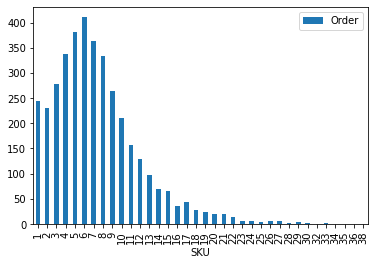

In [0]:
#overall
distribution = data.loc[data.year==2013][['Order', 'SKU']].groupby('Order', as_index=False).count().groupby('SKU').count()
distribution.plot(kind='bar')

At least half of the oredrs only contains 7 distinct products, however there are orders with 42 different products. Orders with lower number of products (ex 1) can also represent when people forget that product. -- Maybe shoul be interesetant merge that orders??

### See orders done in same day and by the same member - possible forgettings that should be merged in one?

In [0]:
data_use=data[['Order', 'Member', 'date']]
c=pd.pivot_table(data=data_use, index=['Member', 'date'], aggfunc=lambda x: len(x.unique()))
c.describe()

,Order
count,8169.000000
mean,1.026564
std,0.174682
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,4.000000


In [0]:
other_percs(c, c.Order.value_counts(), 'Same day Orders') # Group this orders together?

,Same day Orders,Total,Percentage (%)
0,1,7970,97.56%
1,2,182,2.23%
2,3,16,0.20%
3,4,1,0.01%


### How many times the customer buys the same product?

In [0]:
data_use=data[['Order', 'Member', 'SKU_des']]
d=pd.pivot_table(data=data_use, index=['Member', 'SKU_des'], aggfunc=lambda x: len(x.unique()))
d.columns=['Nr Purchases Product']
d.reset_index(inplace=True)
d.describe()

,Nr Purchases Product
count,15480.000000
mean,4.013953
std,6.241749
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,75.000000


at leat 50% of products are repeated

### How much each person enjoys each product? - percentages of orders that that product is present

In [0]:
preferences=d.merge(a, on='Member')
preferences['perc']=preferences.iloc[:,2]/preferences.iloc[:,3]*100
preferences.sort_values(by='perc', ascending=False)

,Member,SKU_des,Nr Purchases Product,Order,perc
15367,M99030,15668460//Gourd & Cucumber,72,78,92.307692
13110,M59232,15669832//Sugar,23,25,92.000000
13121,M59232,15669870//Sooji & Rava,22,25,88.000000
6340,M39021,7580802//Sunflower Oils,42,48,87.500000
15364,M99030,15668453//Brinjals,64,78,82.051282
...,...,...,...,...,...
5352,M36432,15669883//Rice Flour,1,202,0.495050
5496,M36432,7736902//Namkeen,1,202,0.495050
5351,M36432,15669881//Sooji & Rava,1,202,0.495050
5473,M36432,7591078//Regular Pasta,1,202,0.495050


### Holidays purchase
- is there any activity being made on a holiday?

In [0]:
#!pip install holidays
#import the library thta holds the holidays for India
from datetime import date 
import holidays

india_holidays = []
  
# Print all the holidays in UnitedKingdom in years 2018 
for date in holidays.India(years = 2011).items():
    india_holidays.append(str(date[0]))
for date in holidays.India(years = 2012).items():
    india_holidays.append(str(date[0]))
for date in holidays.India(years = 2013).items():
    india_holidays.append(str(date[0]))
for date in holidays.India(years = 2014).items():
    india_holidays.append(str(date[0]))
print(india_holidays) 

['2011-01-14', '2011-01-26', '2011-08-15', '2011-10-02', '2011-05-01', '2011-12-25', '2012-01-14', '2012-01-26', '2012-08-15', '2012-10-02', '2012-05-01', '2012-12-25', '2013-01-14', '2013-01-26', '2013-08-15', '2013-10-02', '2013-05-01', '2013-12-25', '2014-01-14', '2014-01-26', '2014-08-15', '2014-10-02', '2014-05-01', '2014-12-25']


In [0]:
# is there any purchase being made on holidays?
h = data.copy(deep=True)
h['is_holiday'] = h.date.isin(india_holidays).replace(to_replace = False, value = 0)
h.loc[h['is_holiday']!=0]

,index,Member,Order,SKU,Created On,Description,date,day,month,year,SKU_des,is_holiday


There is no special purchases being made in holidays. apparently the shop does not work on holidays. Therefore, the holidays purchase most be made in the days before.

### Weekday special differences 
- Is there a general difference between what is purchased per day on each day of the week?

In [0]:
w= data.copy(deep=True)
w['weekday']= data['Created On'].dt.weekday

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline  

dataw0 = w[['Member', 'Description']].loc[w["weekday"]==0].groupby(by='Description', as_index= False).count().sort_values(by='Member', ascending = False).iloc[0:30,:]
dataw1 = w[['Member', 'Description']].loc[w["weekday"]==1].groupby(by='Description', as_index= False).count().sort_values(by='Member', ascending = False).iloc[0:30,:]
dataw2 = w[['Member', 'Description']].loc[w["weekday"]==2].groupby(by='Description', as_index= False).count().sort_values(by='Member', ascending = False).iloc[0:30,:]
dataw3 = w[['Member', 'Description']].loc[w["weekday"]==3].groupby(by='Description', as_index= False).count().sort_values(by='Member', ascending = False).iloc[0:30,:]
dataw4 = w[['Member', 'Description']].loc[w["weekday"]==4].groupby(by='Description', as_index= False).count().sort_values(by='Member', ascending = False).iloc[0:30,:]
dataw5 = w[['Member', 'Description']].loc[w["weekday"]==5].groupby(by='Description', as_index= False).count().sort_values(by='Member', ascending = False).iloc[0:30,:]
dataw6 = w[['Member', 'Description']].loc[w["weekday"]==6].groupby(by='Description', as_index= False).count().sort_values(by='Member', ascending = False).iloc[0:30,:]
dataw0['weekday'] = 0
dataw1['weekday'] = 1
dataw2['weekday'] = 2
dataw3['weekday'] = 3
dataw4['weekday'] = 4
dataw5['weekday'] = 5
dataw6['weekday'] = 6
dataw0 = dataw0.append(dataw1)
dataw0 = dataw0.append(dataw2)
dataw0 = dataw0.append(dataw3)
dataw0 = dataw0.append(dataw4)
dataw0 = dataw0.append(dataw5)
dataw0 = dataw0.append(dataw6)

overalldataw = dataw0[['Description','weekday']].groupby(by='Description', as_index= False).count().sort_values(by='weekday')
overalldataw = overalldataw.loc[overalldataw.weekday<5]

dataw0 = dataw0.merge(overalldataw, right_on = 'Description', left_on = 'Description')
dataw0[['Description','weekday_x']]

,Description,weekday_x
0,Health Drinks,0
1,Health Drinks,1
2,Health Drinks,5
3,Health Drinks,6
4,"Glucose, Marie & Milk Biscuits",0
5,"Glucose, Marie & Milk Biscuits",2
6,"Glucose, Marie & Milk Biscuits",6
7,Besan,1
8,Besan,3
9,Besan,5


Most of the popular products are bought independently of the day of the week

### Number of times a product is purchased
- the long tail graph
- what are the most popular products?
- how much of the total products they represent?


In [0]:
data_plot = data[['SKU_des']]
data_plot['quantity']=1
data_plot=data_plot.groupby(by=[ 'SKU_des'], as_index=False).sum()
# graph that show the LONG TAIL
data_plot = data_plot.sort_values('quantity', ascending = False).set_index('SKU_des')

data_plot['perc']= data_plot['quantity']/(data_plot.sum()[0])
import matplotlib.pyplot as plt
#%matplotlib inline  

#data_plot.plot(kind='bar')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
data_plot[0:243].sum()

quantity    49735.000000
perc            0.800422
dtype: float64

In [0]:
# products that represent 50% of purchased will be called regular products and will be 
# used to evaluate the recommendation
data_plot[0:60].sum()
regular_products = data_plot[0:60].index.values
#regular_products 

In [0]:
x = data_plot[:243]
x['desc'] = x.index.str.split("//").str[1]
x = x.set_index('desc')
x = x.groupby('desc').sum().sort_values(by ='quantity', ascending = False)
x.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(62, 2)

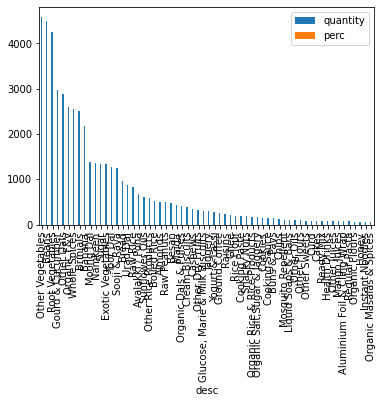

In [0]:
%matplotlib inline  

x.plot(kind='bar')

243 products over 1727 represent 80% of the sells ( 14% of products)
62 products description over the 215 products description are included in this 80%
because of that we have to keep in mind the fallowing statement when doing the recommendation:


**"Diversity
Recommender algorithms are generally designed to give recommendations for popular items because they are popular :) However, a good recommendation system should provide diversity. Same and known items can make the customers bored. Therefore adjusting the threshold, starting point of long-tail, in recommendation system is an important research to take into account. Moving it right in the graph can increase the diversity in recommendations made."**
"https://medium.com/@kyasar.mail/recommender-systems-what-long-tail-tells-91680f10a5b2"

## Consumption over the year

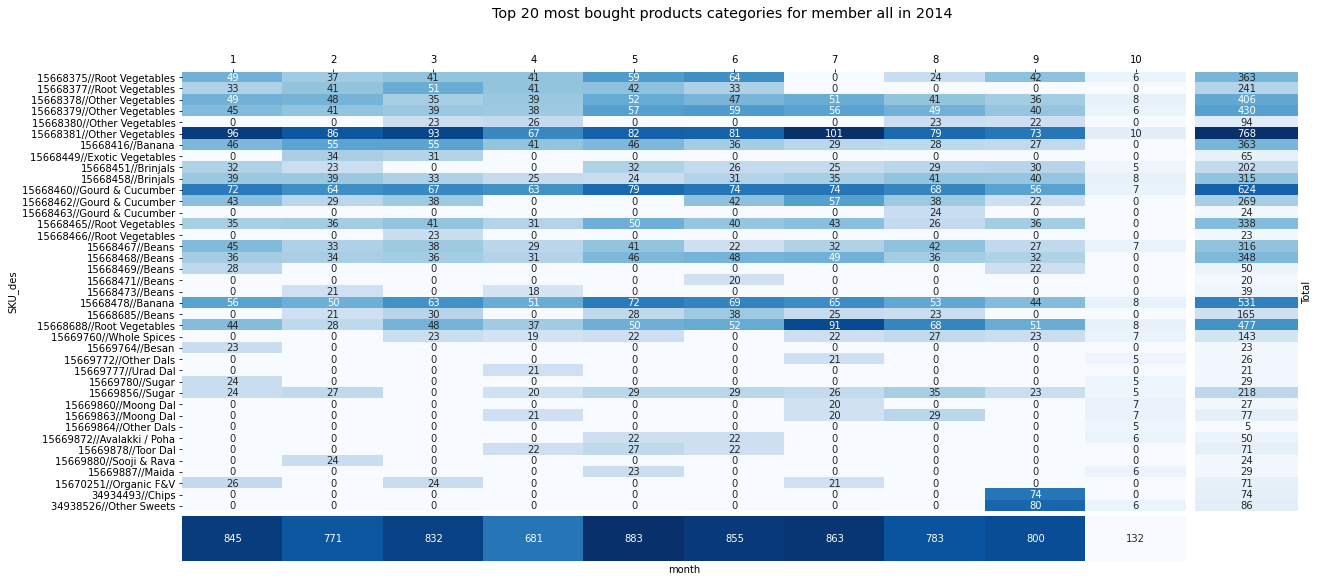

In [0]:
consumpution_tracker(data, 2014, 'all', 'month', 20)

# Data Transformation

In [0]:
rfm_data=data.copy()

 ##### Give same order number to orders done in same day by same member

In [0]:
data=Same_Order_same_Day(data)

## Selecting only orders with more than 4 products in the purchased
- orders with less than 4 products in the purchase may be forget items and will not be use do evaluate the models, as we understand that those purchased will be minimized with the smartbasket and did you forget recommendation systems.


In [0]:
data=Delete_less4items(data)

10.304815243980945 % of the records have been removed.


# Modelling

## Create Trainning and Test Set
- A cut-off date
of 31/07/2014 is set on basis of data analysis

In [0]:
test=data[(data.year>=test_year)&(data.month>=test_month)]
train=data[~data.index.isin(test.index)]
#train=train[(data.year>=2013)]#&(data.month>=1)]

filter out members from train and test that dont have TOPN purchases and match test members to train members.

In [0]:
members_use=list(set(train.Member)& set(test.Member))
train=train[train.Member.isin(members_use)]
test=test[test.Member.isin(members_use)]

In [0]:
print('train shape:', train.shape)
#print('val shape:', val.shape)
print('test shape:', test.shape)

train shape: (45248, 10)
test shape: (5248, 10)


# Smart Basket - Known customer

## Page Rannk Algorithm application to all dataset
- for each member returns a basket with the top Skus ranked given his own purchases (uing page rank algorithm)

**data:** data with all purchases 

**topN:** topN products to select and present as solution

In [0]:
SmartBasket(train, 10)

#for each memb

,M56897,M41747,M56309,M54796,M48154,M86304,M78365,M42182,M18732,M54100,M46575,M43977,M44156,M37600,M56516,M33422,M33558,M43189,M08075,M37253,M32409,M33064,M77779,M52629,M96365,M31908,M36876,M51043,M58939,M45470,M54382,M14746,M43831,M91098,M46687,M27458,M35649,M58761,M31101,M32039,...,M78720,M27871,M35538,M50420,M33491,M41781,M57354,M36702,M76390,M54619,M54345,M64055,M63404,M84827,M12050,M56368,M82651,M59012,M59232,M25900,M57327,M56489,M36432,M31966,M90375,M35464,M16218,M39021,M22037,M64379,M33767,M99206,M62656,M62833,M32480,M48938,M86572,M09736,M32655,M35070
0,15668478//Banana,15668379//Other Vegetables,15668460//Gourd & Cucumber,15668381//Other Vegetables,15668379//Other Vegetables,15668460//Gourd & Cucumber,15668460//Gourd & Cucumber,15668478//Banana,15668381//Other Vegetables,15668458//Brinjals,15668460//Gourd & Cucumber,15669824//Raw Rice,15668416//Banana,7627860//Sunflower Oils,7580823//Sunflower Oils,15669780//Sugar,15668478//Banana,15668378//Other Vegetables,15668465//Root Vegetables,15668478//Banana,15668460//Gourd & Cucumber,15668466//Root Vegetables,15668462//Gourd & Cucumber,15670252//Organic F&V,15668378//Other Vegetables,15668521//Bread,15668468//Beans,15668416//Banana,15669783//Sooji & Rava,15668465//Root Vegetables,15669780//Sugar,15668381//Other Vegetables,93141093//Curd,15669775//Sooji & Rava,15669770//Other Flours,15668460//Gourd & Cucumber,15668478//Banana,15668379//Other Vegetables,15668477//Exotic Vegetables,15668378//Other Vegetables,...,15668478//Banana,15670251//Organic F&V,7586526//Snacky Nuts,7689353//Ground Coffee,15668381//Other Vegetables,7569801//Namkeen,15668462//Gourd & Cucumber,15668457//Brinjals,15668381//Other Vegetables,15668379//Other Vegetables,15669885//Moong Dal,15668416//Banana,15668460//Gourd & Cucumber,15670260//Organic F&V,15668471//Beans,15668460//Gourd & Cucumber,15669780//Sugar,15668416//Banana,15669832//Sugar,15668378//Other Vegetables,15668416//Banana,7625556//Ground Coffee,15668460//Gourd & Cucumber,15668451//Brinjals,15668379//Other Vegetables,7572313//Namkeen,15668416//Banana,7580802//Sunflower Oils,7580802//Sunflower Oils,15668478//Banana,15668466//Root Vegetables,7753779//Health Drinks,15668381//Other Vegetables,15668379//Other Vegetables,15668685//Beans,15668416//Banana,15668520//Bread,7572306//Snacky Nuts,34986119//Whole Spices,15668416//Banana
1,15668467//Beans,15668381//Other Vegetables,15668378//Other Vegetables,15668478//Banana,15668467//Beans,15668380//Other Vegetables,15668377//Root Vegetables,93141092//Yogurt & Lassi,15668458//Brinjals,15668379//Other Vegetables,15668381//Other Vegetables,15669777//Urad Dal,15668460//Gourd & Cucumber,15669870//Sooji & Rava,7623116//Liquid Soaps & Bars,15669787//Raw Rice,15668462//Gourd & Cucumber,15668416//Banana,15668460//Gourd & Cucumber,15668469//Beans,15668458//Brinjals,15668463//Gourd & Cucumber,15668458//Brinjals,7572730//Other Juices,15669785//Boiled Rice,15668379//Other Vegetables,15668375//Root Vegetables,7627860//Sunflower Oils,15669880//Sooji & Rava,15669856//Sugar,15669857//Raw Peanuts,15668460//Gourd & Cucumber,15668478//Banana,7580802//Sunflower Oils,15669777//Urad Dal,15668381//Other Vegetables,15668688//Root Vegetables,15668478//Banana,15670251//Organic F&V,15668381//Other Vegetables,...,15668381//Other Vegetables,15668688//Root Vegetables,15668465//Root Vegetables,15669817//Whole Spices,15668462//Gourd & Cucumber,15668381//Other Vegetables,15668685//Beans,15668474//Beans,15669767//Urad Dal,15668478//Banana,15669866//Other Dals,15668460//Gourd & Cucumber,15668462//Gourd & Cucumber,15668416//Banana,15668468//Beans,15668473//Beans,15669988//Other Dals,15668460//Gourd & Cucumber,15669870//Sooji & Rava,15668478//Banana,15669776//Other Dals,7580823//Sunflower Oils,15669872//Avalakki / Poha,15668467//Beans,15669863//Moong Dal,15669821//Whole Spices,15668378//Other Vegetables,15668379//Other Vegetables,15668379//Other Vegetables,"7629391//Glucose, Marie & Milk Biscuits",15668416//Banana,15668688//Root Vegetables,15668463//

## Validation

- **model to use**
- **dataset** to work with
- **dataset** to test
- **the number of products to be recommended in the smartbasket**
- **the number of times the validations should occour**
- **the number of members in each validation time**

In [0]:
Times_to_run=20
Number_of_customer = 50

### Analysis of random recommendation with Monte Carlo Cross validation

- This model was created to be a comparison to other model

In [0]:
validation('random', train, test, 10, Times_to_run, Number_of_customer) # (model, trainset,testset TopN, times_to_run, N)

the precision is 0.067 +/- 0.08803976374343585 
 the recall is 0.06475153313132892+/- 0.08640520078544395 
 the F1 is 0.061705875789850366+/- 0.07724094456311677 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.2826+/- 0.148314665491987 .


In [0]:
validation('random', train, test, 15, Times_to_run, Number_of_customer) # (model, trainset,testset TopN, times_to_run, N)

the precision is 0.06913333333333332 +/- 0.07727673216003206 
 the recall is 0.10204040429664799+/- 0.11039145788042615 
 the F1 is 0.0774376254474157+/- 0.08021883135618593 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.28820000000000007+/- 0.12959202650369092 .


In [0]:
validation('random', train, test, 20, Times_to_run, Number_of_customer) # (model, trainset,testset TopN, times_to_run, N)

the precision is 0.0685 +/- 0.06758513150094479 
 the recall is 0.13705693133882635+/- 0.12539040707052487 
 the F1 is 0.0860027329033126+/- 0.07641784589212539 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.286+/- 0.1153429668423697 .


### Analysis of Model recommendation with Monte Carlo Cross validation

**Pagerank**

In [0]:
validation('',train, test, 10, Times_to_run, Number_of_customer) 

the precision is 0.2955 +/- 0.20588771211512355 
 the recall is 0.3002896618855958+/- 0.18725290241108158 
 the F1 is 0.28075889801526005+/- 0.1640834563764069 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.6891+/- 0.18256831598062137 .


In [0]:
validation('',train, test, 15, Times_to_run, Number_of_customer) 

the precision is 0.2532666666666667 +/- 0.1767685115247245 
 the recall is 0.3784707847840971+/- 0.20976877361365442 
 the F1 is 0.2856951412568253+/- 0.15851216062255144 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.6506+/- 0.16707841139882662 .


In [0]:
validation('',train, test, 20, Times_to_run, Number_of_customer) 

the precision is 0.2206 +/- 0.15172554168629618 
 the recall is 0.436691187408754+/- 0.2250942623440893 
 the F1 is 0.276416609239477+/- 0.15012675230091735 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.6154+/- 0.1420135204830864 .


- the F1 results for the page rank model seems perform very similarly with 10 to 20 products for the smart basket. But the recall is better when we have a higher number of products.
- The model seems to be performing well, not recommending only regular products, but a mix of products

**Most frequent items**

In [0]:
validation('freq', train, test, 10, Times_to_run, Number_of_customer) 

the precision is 0.2914 +/- 0.19505394125728398 
 the recall is 0.30249246163067645+/- 0.19061830576139538 
 the F1 is 0.2802740562469681+/- 0.16318407718274597 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.7104000000000001+/- 0.18966243697685634 .


In [0]:
validation('freq', train, test, 15, Times_to_run, Number_of_customer) 

the precision is 0.25260000000000005 +/- 0.1691610540940858 
 the recall is 0.38152349968255+/- 0.20995156900930798 
 the F1 is 0.286685086142136+/- 0.15595451889175904 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.6615999999999999+/- 0.1518804207994639 .


In [0]:
validation('freq', train, test, 20, Times_to_run, Number_of_customer) 

the precision is 0.22255 +/- 0.14794930719675575 
 the recall is 0.44437014524309837+/- 0.22397382716769876 
 the F1 is 0.2801065064904783+/- 0.1476159976592442 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.63615+/- 0.14443225920825306 .


- Very similar performance compared to the page rank

**mix of Pagerank with frequant item**

In [0]:
validation('mix', train, test, 10, Times_to_run, Number_of_customer) 

the precision is 0.2955 +/- 0.20588771211512355 
 the recall is 0.3002896618855958+/- 0.18725290241108158 
 the F1 is 0.28075889801526005+/- 0.1640834563764069 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.6891+/- 0.18256831598062137 .


In [0]:
validation('mix', train, test, 15, Times_to_run, Number_of_customer) 

the precision is 0.2526666666666667 +/- 0.17501618972731256 
 the recall is 0.37810329199486525+/- 0.20959972978612199 
 the F1 is 0.2852467202041937+/- 0.15771465430301448 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.6506+/- 0.16707841139882662 .


In [0]:
validation('mix', train, test, 20, Times_to_run, Number_of_customer) 

the precision is 0.22200000000000003 +/- 0.15174320413119002 
 the recall is 0.43952567749596155+/- 0.22478439908175502 
 the F1 is 0.27832475713164867+/- 0.15036658459978217 
 the regular_shop is 0.4570635677670125+/- 0.23081737431244248 
 the regular_recom is 0.62005+/- 0.1435983896149257 .


- Very similar performance

### Validation of all test set

In [0]:
validation_not_random(train, 15)

Precision: 0.3 +/- 0.16 
   Recall: 0.49 +/- 0.21


# Did You Forget - Known customer

## Select Next in Basket using Similiarity Measures

**data:** data with all purchases 

**member:** member to look to

**similiarity_measure:** cosine_similiarity, jaccard_similiarity or dice_similiarity

**bastek:** Skus of items already contained in basket

**topN:** topN products to select and present as solution

In [0]:
select_next_inBasket(data, 'M59232',jaccard_similarity,  ['34934493//Chips',
  '7610713//Corn Snacks',
  '15669863//Moong Dal',
  '34934494//Chips',
  '15668478//Banana'], 2)

SKU_des
15669857//Raw Peanuts     0
15669781//Rice Flour      1
15669886//Sooji & Rava    2
Name: Rank, dtype: int64

## Select Next in Basket using Page Rank

**data:** data with all purchases 

**member:** member to look to

**bastek:** Skus of items already contained in basket

**topN:** topN products to select and present as solution

In [0]:
PageRank_nextBasket(data, 'M09736', ['34934493//Chips',
  '7610713//Corn Snacks',
  '15669863//Moong Dal',
  '34934494//Chips',
  '15668478//Banana'], 2)

,SKU_des,M09736
0,15669856//Sugar,0.977667
1,21409124//Sugar Cubes,0.939060
2,7572306//Snacky Nuts,0.903656


## MBA

In [0]:
Basket_analysis(train,'M27458',  ['34934493//Chips',
  '7610713//Corn Snacks',
  '15669863//Moong Dal',
  '34934494//Chips',
  '15668478//Banana'],2)


['15668381//Other Vegetables']

## Validation

- **dataset** to work with
- **dataset** to test
- **the number os products to be recommended in the smartbasket**
- **the number of times the validations should occour**
- **algorithm to used** jaccard, cosine, MBA or pageRank( none is page rank)
- **the number of members in each validation time**

In [0]:
times_to_run = 5
number_of_customer = 10

### Analysis of random recommendation with Monte Carlo Cross validation

In [0]:
validation_DYF(train, test, 3, times_to_run, 'random', number_of_customer)

the precision is 0.026666666666666665+/- 0.09043106644167023 
 the recall is 0.020538461538461537+/- 0.08213717059224411 
 the F1 is 0.021214285714285713+/- 0.07710452089765646 .


In [0]:
validation_DYF(train, test, 5, times_to_run, 'random', number_of_customer)

the precision is 0.016+/- 0.054258639865002144 
 the recall is 0.021666666666666664+/- 0.08629728977333077 
 the F1 is 0.01670359052711994+/- 0.05951148425738285 .


### Analysis of models recommendation with Monte Carlo Cross validation
**Page Rank**

In [0]:
validation_DYF(train, test, 3, times_to_run, '', number_of_customer)

the precision is 0.14666666666666667+/- 0.20176994600562076 
 the recall is 0.10910989010989011+/- 0.18506386964085947 
 the F1 is 0.11683333333333333+/- 0.170729174595911 .


In [0]:
validation_DYF(train, test, 5, times_to_run, '', number_of_customer)

the precision is 0.14400000000000002+/- 0.17906423428479515 
 the recall is 0.186967032967033+/- 0.24507205314876884 
 the F1 is 0.15094423223834988+/- 0.17603733708691685 .


**Similiarity Metrics**

as the similarity metrics takes more time to run we will only run for the better amount of products, from the previous model (5)

In [0]:
times_to_run = 5
number_of_customer = 5

In [0]:
validation_DYF(train, test, 5, times_to_run, 'jaccard', number_of_customer)

the precision is 0.136+/- 0.14664242223858687 
 the recall is 0.20252525252525252+/- 0.23459295319424908 
 the F1 is 0.15236507936507937+/- 0.16680177743478752 .


In [0]:
validation_DYF(train, test, 5, times_to_run, 'cosine', number_of_customer)

the precision is 0.11200000000000002+/- 0.15051910177781425 
 the recall is 0.1591919191919192+/- 0.23187026548991888 
 the F1 is 0.12204761904761906+/- 0.1685280815938824 .


In [0]:
validation_DYF(train, test, 5, times_to_run, 'dice', number_of_customer)

the precision is 0.136+/- 0.14664242223858687 
 the recall is 0.20252525252525252+/- 0.23459295319424908 
 the F1 is 0.15236507936507937+/- 0.16680177743478752 .


**MBA**

In [0]:
validation_DYF(train, test, 5, 5, 'MBA', 5)

the precision is 0.16+/- 0.24657656011875903 
 the recall is 0.1909062049062049+/- 0.229377574427692 
 the F1 is 0.1561746031746032+/- 0.1979092686288883 .


# Smart Basket - New Customers

In [0]:
SmartBasket_newCust(data, 10)

['15668381//Other Vegetables',
 '15668688//Root Vegetables',
 '15668460//Gourd & Cucumber',
 '15668379//Other Vegetables',
 '15668468//Beans',
 '15668378//Other Vegetables',
 '15668467//Beans',
 '15668478//Banana',
 '15668465//Root Vegetables',
 '15668462//Gourd & Cucumber',
 '15668416//Banana']

## Validation
**Page rank**

In [0]:
validation_NEW(train, test, 20, 20, 50)

the precision is 0.13035 +/- 0.09061665133958549 
 the recall is 0.3749823848036846+/- 0.24993702779311078 
 the F1 is 0.1835185172794205+/- 0.11678604830991061 
 the regular_shop is 0.6387460280455892+/- 0.24448417292863897 
 the regular_recom is 1.0+/- 0.0 .


# Did you forget? - NEW customer

### Page Rank

In [0]:
PageRank_nextBasket_newCust(data,
                            ['34934493//Chips',
                            '7610713//Corn Snacks',
                            '15669863//Moong Dal',
                            '34934494//Chips',
                            '15668478//Banana'], 5)

,SKU_des,ranks
0,15668381//Other Vegetables,35.930818
1,15668688//Root Vegetables,31.230789
2,15668460//Gourd & Cucumber,28.764874
3,15668379//Other Vegetables,25.643031
4,15668468//Beans,21.569341
5,15668378//Other Vegetables,20.775318


In [0]:
validation_DYF_NEW(train, test,5,10,'',30)

the precision is 0.14266666666666666+/- 0.17789385099609886 
 the recall is 0.11839397139440355+/- 0.1595071704687216 
 the F1 is 0.12261491280190971+/- 0.15561616664084268 .


### - Similiarity Measures

In [0]:
select_next_inBasket_newCust(data, cosine_similarity,
                             ['34934493//Chips',
                            '7610713//Corn Snacks',
                            '15669863//Moong Dal',
                            '34934494//Chips',
                            '15668478//Banana'], 5)

SKU_des
15668468//Beans               0
15668688//Root Vegetables     1
15668379//Other Vegetables    2
15668381//Other Vegetables    3
15669860//Moong Dal           4
15669864//Other Dals          5
Name: Rank, dtype: int64

In [0]:
times_to_run = 10
number_of_customer = 30

In [0]:
validation_DYF_NEW(train, test,5,times_to_run,'cosine',number_of_customer)

the precision is 0.20666666666666667+/- 0.278966346038769 
 the recall is 0.16596190776466552+/- 0.21909590386004665 
 the F1 is 0.17331367513942733+/- 0.2250845264122763 .


In [0]:
validation_DYF_NEW(train, test,5,times_to_run,'jaccard',number_of_customer)

the precision is 0.20866666666666664+/- 0.2810543640571261 
 the recall is 0.16845649650925423+/- 0.22215625836382444 
 the F1 is 0.17517850205242866+/- 0.22738533987220788 .


In [0]:
validation_DYF_NEW(train, test,5,times_to_run,'dice',number_of_customer)

the precision is 0.20866666666666664+/- 0.2810543640571261 
 the recall is 0.16845649650925423+/- 0.22215625836382444 
 the F1 is 0.17517850205242866+/- 0.22738533987220788 .


## MBA - with Description NOT SKU

In [0]:
Basket_analysis_new_customers(train,['Other Dals', 'Gourd & Cucumber', 'Brinjals', 'Other Vegetables'], 2 )

['Brinjals', 'Other Dals', 'Beans', 'Urad Dal']

In [0]:
validation_DYF_NEW_MBA(train, test, 5, 10, 30)

the precision is 0.21733333333333335+/- 0.37978005330571124 
 the recall is 0.16143147881055728+/- 0.2371051663549248 
 the F1 is 0.17080969291910048+/- 0.24899412517199146 
 the regular_shop is 0.0+/- 0.0 
 the regular_recom is 0.0+/- 0.0 .


# RFQ


In order to perform this analysis we have to calculate the folowing vaiables:
 - Recency (days since last purchase): Using the difference of the maximum date on the dataset and the maximum date of the given customer (summing 1 day). 

 - Frequency (Number of customers’ orders): Counting the different number of invoices (count the unique Orders associated to the customer). 

 - Quantity (Total Amount spent by the customer translated in Quantity): count all products purchased by the given customer.

In [0]:
snapshot_date = rfm_data['date'].max() + timedelta(days=1) #add an extra day?

data_process = rfm_data.groupby(['Member']).agg({
        'date': lambda x: (snapshot_date - x.max()).days,
        'Order': lambda x: len(x.unique()),
        'SKU': 'count'})
data_process.rename(columns={'date': 'Recency',
                         'Order': 'Frequency',
                         'SKU': 'Quantity'}, inplace=True)

In [0]:
data_process

,Recency,Frequency,Quantity
Member,,,
M04158,97,132,492
M08075,1,55,638
M09303,1,105,463
M09736,9,62,626
M12050,6,39,556
...,...,...,...
M90375,7,79,412
M91098,7,66,483
M96365,1,73,402


Outliers

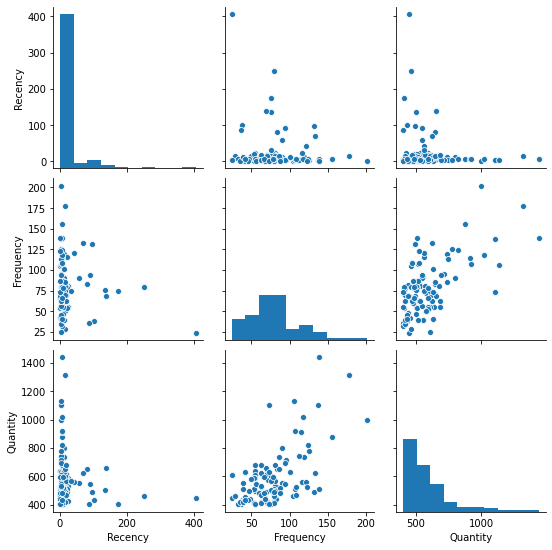

In [0]:
sns.pairplot(data_process,
            diag_kind='hist',
            kind='scatter',
            palette='hus1')
#the three variables appear to have outliers

In [0]:
len(data_process)*0.01

1.06

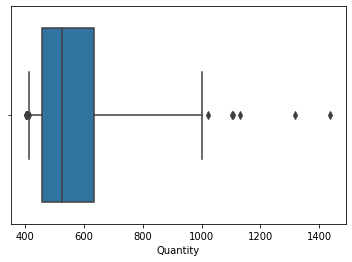

In [0]:
sns.boxplot(x = data_process['Quantity'], orient='h', whis=[5,95])#5

In [0]:
len(data_process[data_process['Quantity']>1200])

2

In [0]:
#data_process=data_process[data_process['Quantity']<=1200]

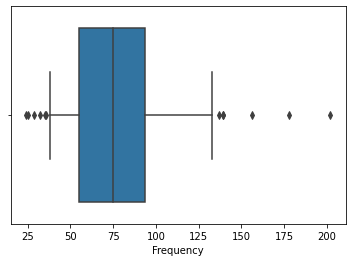

In [0]:
sns.boxplot(x = data_process['Frequency'], orient='h', whis=[5,95])

In [0]:
len(data_process[data_process['Frequency']>140])

3

In [0]:
#data_process=data_process[data_process['Frequency']<=140]

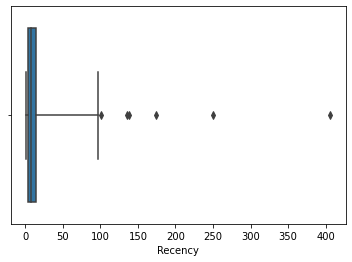

In [0]:
sns.boxplot(x = data_process['Recency'], orient='h', whis=[5,95])

In [0]:
len(data_process[data_process['Recency']>300])

1

In [0]:
data_process=data_process[data_process['Recency']<=300]

## Clustering

In [0]:
# Scaling the Data 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform((data_process))
X1 = pd.DataFrame(X_scaled, columns=(data_process.columns))

In [0]:
# Fitting the PCA algorithm with our Data
pca = PCA().fit(X1)

# Showing the percentage explained by each compomonent and 
# and the cumulative sum of this percentage on a table
pca_board = pd.DataFrame({"Explained var. (%)":np.round(pca.explained_variance_ratio_*100, decimals = 1),
                          "Cumulative var. (%)":np.round(np.cumsum(pca.explained_variance_ratio_*100), decimals = 2)})
pca_board.index.name = 'PC'
pca_board.index += 1 
print (pca_board)  #not use pca

    Explained var. (%)  Cumulative var. (%)
PC                                         
1                 53.9                53.91
2                 33.3                87.21
3                 12.8               100.00


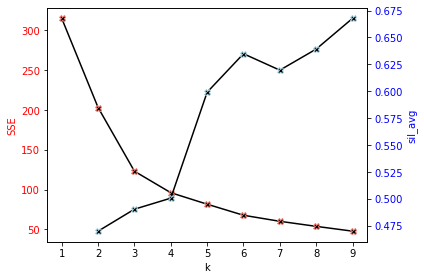

In [0]:
sse=sse_vals(X1, 10)
sil=sill_scores(X1, 10)

sil_sse_plot(sil, sse)

In [0]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=123).fit(X1)  
my_clusters = kmeans.cluster_centers_ 
my_clusters = pd.DataFrame(kmeans.cluster_centers_)
y_kmeans = kmeans.predict(X1)

In [0]:
data_process.groupby(y_kmeans).size().apply("{:,.0f}".format)

0    18
1    45
2    42
dtype: object

In [0]:
centroids1 = pd.DataFrame(data_process.groupby(y_kmeans).mean())
centroids1['Avg Quantity per Order']=centroids1.Quantity/centroids1.Frequency
centroids1.transpose()

,0,1,2
Recency,7.888889,22.066667,22.952381
Frequency,73.277778,72.844444,89.642857
Quantity,708.666667,574.666667,549.357143
Avg Quantity per Order,9.670963,7.888957,6.128287


**Cluster 0  - Best Customers:** 

Come frequently and purchasing the biggest amounts of products. In average they haent return for more than a week, this can be explained by their shopping behaviour.

**Cluster 1 - Good Customers:**

In average they havent done purchases for 3 weeks, coming frequently and purchasing smaller quantities of products. 

**Cluster 2 - Bad Customers:**

In average they are costumer that havent purchases in 3 weeks, the ones that came the biggest amount of times but purchasing smaller quantities of products.
